In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pysal as ps
%matplotlib inline
%config IPCompleter.greedy=True

/home/steve/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [3]:
df = pd.read_csv('fent_county_year.txt', sep = '\t')
fent_all_years = pd.read_csv('all_fentanyl_by_county.txt', sep = '\t')
fent_13_17 = pd.read_csv('all_fent_by_county_13-17.txt', sep = '\t')
national_fent = pd.read_csv('national_fent.txt', sep = '\t')
national_all_opioids = pd.read_csv('grouped_by_year_not_county_all_opioids.txt', sep = '\t')
national_fent_cocaine = pd.read_csv('fent_and_cocaine.txt', sep = '\t')
fent_by_state = pd.read_csv('fent_state.txt', sep = '\t')

In [4]:
df = df.drop('Notes', axis = 'columns')
df = df.dropna()
df = df.drop('Year Code', axis = 'columns')
df.columns = ['county', 'county_code', 'year', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_all_years = fent_all_years.drop('Notes', axis = 'columns')
fent_all_years = fent_all_years.dropna()
fent_all_years.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_13_17 = fent_13_17.drop('Notes', axis = 'columns')
fent_13_17 = fent_13_17.dropna()
fent_13_17.columns = ['county', 'county_code', 'deaths', 'population', 'crude_rate', 'aa_rate']

national_fent = national_fent.drop('Notes', axis = 'columns')
national_fent = national_fent.dropna()
national_fent = national_fent.drop('Year Code', axis = 'columns')
national_fent.columns = ['year', 'deaths', 'population', 'crude_rate', 'aa_rate']

national_all_opioids = national_all_opioids.drop('Notes', axis = 'columns')
national_all_opioids = national_all_opioids.dropna()
national_all_opioids = national_all_opioids.drop('Year Code', axis = 'columns')
national_all_opioids.columns = ['year', 'deaths', 'population', 'crude_rate']

national_fent_cocaine = national_fent_cocaine.drop('Notes', axis = 'columns')
national_fent_cocaine = national_fent_cocaine.dropna()
national_fent_cocaine = national_fent_cocaine.drop('Year Code', axis = 'columns')
national_fent_cocaine.columns = ['year', 'deaths', 'population', 'crude_rate', 'aa_rate']

fent_by_state = fent_by_state.drop(['Notes', 'Year Code'], axis = 'columns')
fent_by_state = fent_by_state.dropna()
fent_by_state.columns = ['state', 'state_code', 'year', 'deaths', 'population', 'crude_rate', 'aa_rate']

In [5]:
counties = gpd.read_file('us-counties.json')

In [6]:
# for now put suppressed entries to 0
def convert_suppressed(entry):
    if entry == 'Suppressed':
        return 0
    elif entry == 'Missing':
        return 0
    elif entry == 'Unreliable':
        return 0
    else:
        return int(entry)
    
df['deaths'] = df['deaths'].apply(convert_suppressed)
fent_all_years['deaths'] = fent_all_years['deaths'].apply(convert_suppressed)
fent_13_17['deaths'] = fent_13_17['deaths'].apply(convert_suppressed)
national_fent['deaths'] = national_fent['deaths'].apply(convert_suppressed)
national_all_opioids['deaths'] = national_all_opioids['deaths'].apply(convert_suppressed)
national_fent_cocaine['deaths'] = national_fent_cocaine['deaths'].apply(convert_suppressed)
fent_by_state['deaths'] = fent_by_state['deaths'].apply(convert_suppressed)

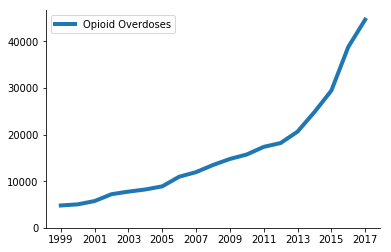

In [7]:
ax = plt.subplot(111)
x = national_all_opioids.year
y = national_all_opioids.deaths
ax.plot(x, y, linewidth = 4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(1999, 2018, 2))
plt.yticks(range(0, 50000, 10000))
plt.rcParams["figure.figsize"] = [12,7]
plt.legend(['Opioid Overdoses'])
plt.savefig('Opioid Overdoses.png')

In [8]:
opioids_no_fent = national_all_opioids.copy()
opioids_no_fent['deaths'] = opioids_no_fent['deaths'] - national_fent.deaths + national_fent_cocaine.deaths

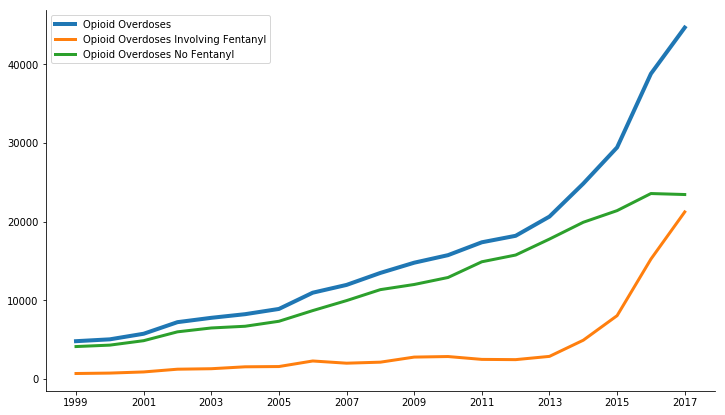

In [9]:
ax = plt.subplot(111)
x = national_all_opioids.year
y = national_all_opioids.deaths
ax.plot(x, y, linewidth = 4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(range(1999, 2018, 2))
plt.yticks(range(0, 50000, 10000))
plt.rcParams["figure.figsize"] = [12,7]
y = national_fent.deaths - national_fent_cocaine.deaths
ax.plot(x, y, linewidth = 3)
y = opioids_no_fent.deaths
ax.plot(x, y, linewidth = 3)
plt.legend(['Opioid Overdoses', 'Opioid Overdoses Involving Fentanyl', 'Opioid Overdoses No Fentanyl'])
plt.savefig('Opioid Overdoses with Fentanyl.png')

In [10]:
counties.columns = ['county_code', 'name', 'geometry']
counties.county_code = counties.county_code.apply(int)
df.county_code = df.county_code.apply(int)

def convert_suppressed_rate(entry):
    if entry == 'Suppressed':
        return 0
    elif entry == 'Missing':
        return 0
    elif entry == 'Unreliable':
        return 0
    else:
        return float(entry)
    
def calculate_rate(row):
    try:
        deaths = float(row.deaths)
    except ValueError:
        deaths = 0
    try:
        population = float(row.population)
    except ValueError:
        population = 1
    return deaths/population * 100000
    
df['crude_rate'] = df['crude_rate'].apply(convert_suppressed_rate)
df['aa_rate'] = df['aa_rate'].apply(convert_suppressed_rate)
df['calculated_crude_rate'] = df.apply(calculate_rate, axis = 'columns')
geodf = counties.merge(df, on = 'county_code')

In [11]:
# dropping hawaii and alaska because they make the map ugly
geodf['state'] = geodf.county.apply(lambda x: x[-2:])
geodf = geodf[geodf['state'] != 'AK']
geodf = geodf[geodf['state'] != 'HI']

In [12]:
def get_color(value):
    if value > 50:
        return 1
    elif value > 35:
        return 0.75
    elif value > 20:
        return 0.5
    elif value > 0:
        return 0.25
    else:
        return 0
        
geodf['test_color'] = geodf['calculated_crude_rate'].apply(get_color)

In [13]:
geodf[geodf.year==2014].sort_values(by = 'test_color', ascending = False)

,county_code,name,geometry,county,year,deaths,population,crude_rate,aa_rate,calculated_crude_rate,state,test_color
11646,45045,Greenville,"POLYGON ((-82.353373 35.192872, -82.216449 35....","Greenville County, SC",2014.0,19,482752,0.0,0.0,3.935768,SC,0.25
10421,39099,Mahoning,"POLYGON ((-80.786968 41.135353, -80.518598 41....","Mahoning County, OH",2014.0,12,233204,0.0,0.0,5.145709,OH,0.25
6526,26163,Wayne,"POLYGON ((-82.879159 42.449818, -82.868205 42....","Wayne County, MI",2014.0,39,1764804,2.2,2.3,2.209877,MI,0.25
12326,47093,Knox,"POLYGON ((-83.92525500000001 36.173245, -83.73...","Knox County, TN",2014.0,18,448644,0.0,0.0,4.012090,TN,0.25
14816,54011,Cabell,"POLYGON ((-82.265742 38.599529, -82.216449 38....","Cabell County, WV",2014.0,11,97109,0.0,0.0,11.327477,WV,0.25
8706,32003,Clark,"POLYGON ((-114.081288 36.841432, -114.048427 3...","Clark County, NV",2014.0,18,2069681,0.0,0.0,0.869699,NV,0.25
10971,40143,Tulsa,"POLYGON ((-95.919754 36.425184, -95.810215 36....","Tulsa County, OK",2014.0,10,629598,0.0,0.0,1.588315,OK,0.25
1721,12057,Hillsborough,"POLYGON ((-82.649128 28.171435, -82.106911 28....","Hillsborough County, FL",2014.0,17,1316298,0.0,0.0,1.291501,FL,0.25
10406,39093,Lorain,"POLYGON ((-81.969987 41.507785, -81.876879 41....","Lorain County, OH",2014.0,14,304216,0.0,0.0,4.601993,OH,0.25
10411,39095,Lucas,"POLYGON ((-83.16396 41.6228, -83.180391 41.622...","Lucas County, OH",2014.0,22,435286,5.1,5.7,5.054148,OH,0.25


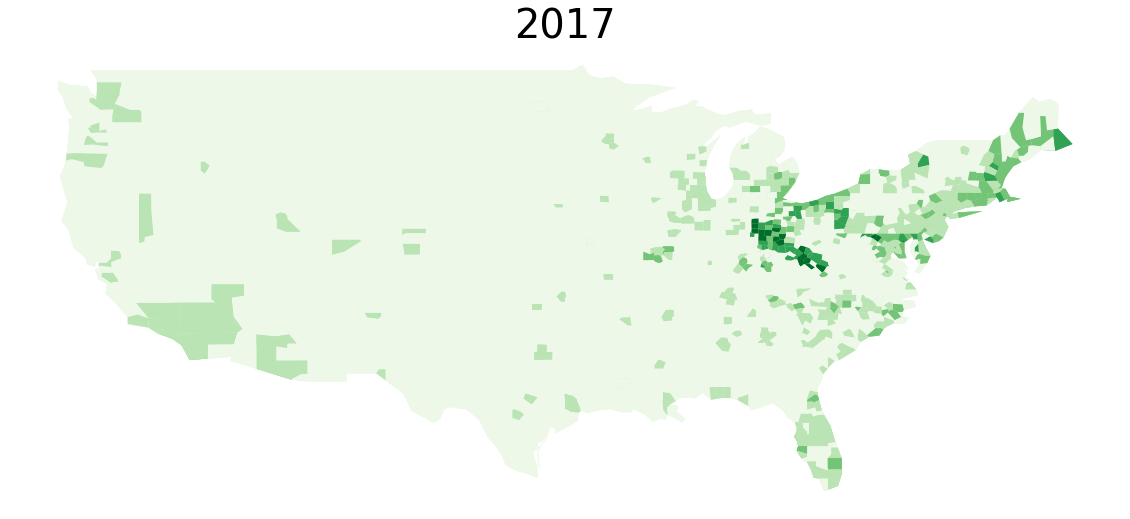

In [14]:
f, ax = plt.subplots(1, figsize=(20, 20))
# each year needs slightly different color maps because I want the maps to use the same colors across years
cmap13 = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#edf8e9'), (1, '#bae4b3')])
cmap14 = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#edf8e9'), (1, '#bae4b3')])
cmap15 = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#edf8e9'), (0.25, '#bae4b3'), (0.50, '#74c476'), (1, '#31a354')])
cmap16 = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#edf8e9'), (0.25, '#bae4b3'), (0.50, '#74c476'), (0.75, '#31a354'), (1, '#006d2c')])
cmap17 = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#edf8e9'), (0.25, '#bae4b3'), (0.50, '#74c476'), (0.75, '#31a354'), (1, '#006d2c')])
ax = geodf[geodf.year == 2013].plot(column = 'test_color', ax = ax, cmap = cmap13)
plt.title('2013', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('2013map.png')

ax = geodf[geodf.year == 2014].plot(column = 'test_color', ax = ax, cmap = cmap14)
plt.title('2014', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('2014map.png')

ax = geodf[geodf.year == 2015].plot(column = 'test_color', ax = ax, cmap = cmap15)
plt.title('2015', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('2015map.png')

ax = geodf[geodf.year == 2016].plot(column = 'test_color', ax = ax, cmap = cmap16)
plt.title('2016', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('2016map.png')

ax = geodf[geodf.year == 2017].plot(column = 'test_color', ax = ax, cmap = cmap17)
plt.title('2017', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('2017map.png')

In [15]:
rent_burden = pd.read_csv('ACS_17_5YR_B25070_with_ann.csv')
rent_burden = rent_burden[['GEO.id2', 'GEO.display-label', 'HD01_VD01', 'HD01_VD10']]
rent_burden.columns = ['county_code', 'county', 'total_renters', 'burden_over_50_percent']
rent_burden['percent_in_distress'] = rent_burden['burden_over_50_percent']/rent_burden['total_renters']
rent_burden = rent_burden[['county_code', 'percent_in_distress']]
geodf = geodf.merge(rent_burden, on = 'county_code')

In [16]:
states = ['WI', 'MO', 'IL', 'IN', 'MI', 'OH', 'KY', 'PA', 'WV', 'NC', 'VA', 'MD', 'DE', 'NJ', 'NY', 'CT', 'RI',
         'MA', 'VT', 'NH', 'ME', 'SC', 'GA', 'FL', 'TN']

In [17]:
small_geodf = geodf[geodf.state.isin(states)]

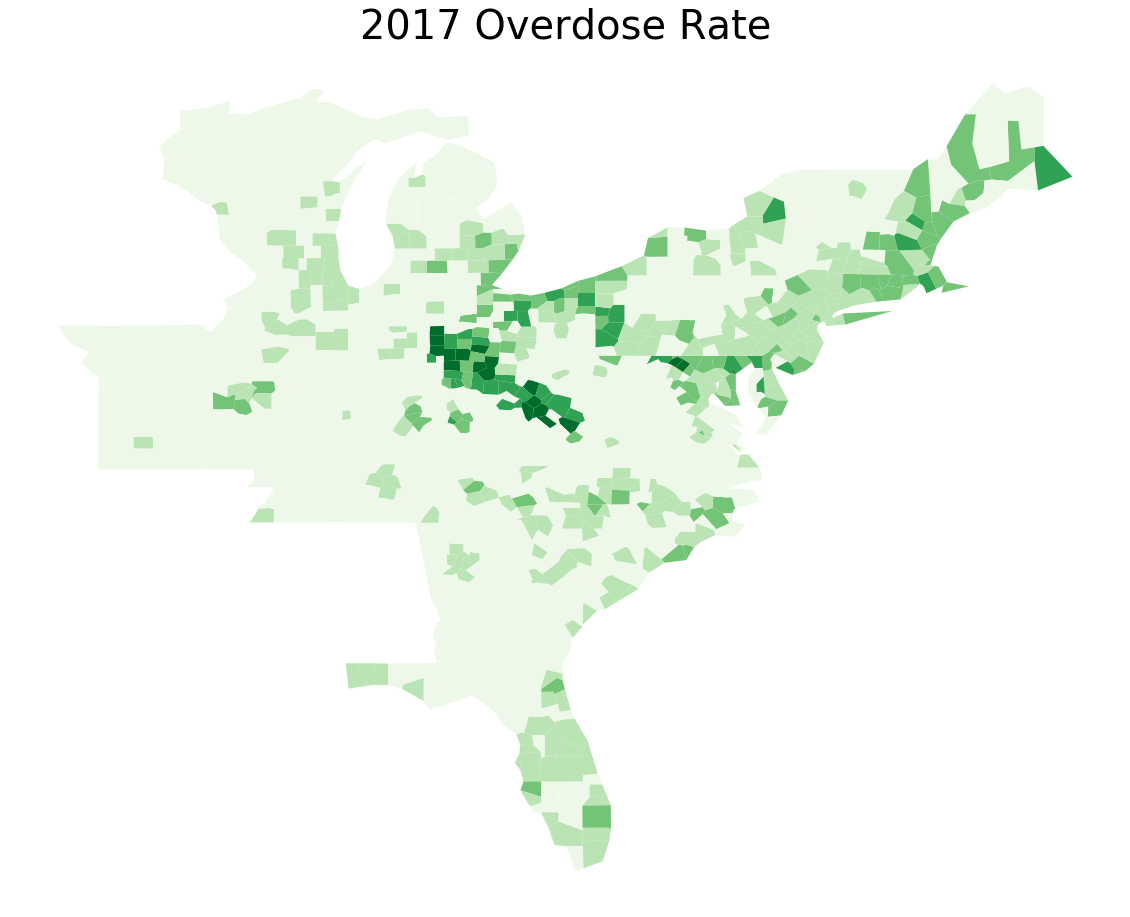

In [18]:
f, ax = plt.subplots(1, figsize=(20, 20))
ax = small_geodf[small_geodf.year == 2017].plot(column = 'test_color', ax = ax, cmap = cmap17)
plt.title('2017 Overdose Rate', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
for year in range(2013, 2018):
    geodf[geodf.year == year].to_file(drive = 'ESRI Shapefile', filename = 'geodf' + str(year) + '.shp')

In [20]:
w17 = ps.queen_from_shapefile('geodf2017.shp')
w16 = ps.queen_from_shapefile('geodf2016.shp')
w15 = ps.queen_from_shapefile('geodf2015.shp')
w14 = ps.queen_from_shapefile('geodf2014.shp')
w13 = ps.queen_from_shapefile('geodf2013.shp')

/home/steve/anaconda3/lib/python3.7/site-packages/pysal/core/IOHandlers/pyShpIO.py:172: RuntimeWarning: SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
  warn("SHAPEFILE WARNING: Polygon %d topology has been fixed. (ccw -> cw)" % (self.pos), RuntimeWarning)


SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)


/home/steve/anaconda3/lib/python3.7/site-packages/pysal/core/IOHandlers/pyShpIO.py:172: RuntimeWarning: SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
  warn("SHAPEFILE WARNING: Polygon %d topology has been fixed. (ccw -> cw)" % (self.pos), RuntimeWarning)


SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 195 topology has been fixed. (ccw -> cw)
SHAPEFILE WARNING: Polygon 2880 topolog

In [21]:
# row standardization 
w17.transform = 'r'
w16.transform = 'r'
w15.transform = 'r'
w14.transform = 'r'
w13.transform = 'r'

In [22]:
# w17.remap_ids(list(geodf[geodf.year == 2017]['county']))

In [23]:
geo17 = geodf[geodf.year == 2017]
geo16 = geodf[geodf.year == 2016]
geo15 = geodf[geodf.year == 2015]
geo14 = geodf[geodf.year == 2014]
geo13 = geodf[geodf.year == 2013]

rate_lag17 = ps.lag_spatial(w17, geodf[geodf.year == 2017]['calculated_crude_rate'])
geo17['rate_lag'] = rate_lag17
geo17['rate_std'] = (geo17['calculated_crude_rate'] - geo17['calculated_crude_rate'].mean()) / geo17['calculated_crude_rate'].std()
geo17['rate_std_lag'] = ps.lag_spatial(w17, geo17['rate_std'])

rate_lag17 = ps.lag_spatial(w17, geodf[geodf.year == 2017]['calculated_crude_rate'])
geo17['rate_lag'] = rate_lag17
geo17['rate_std'] = (geo17['calculated_crude_rate'] - geo17['calculated_crude_rate'].mean()) / geo17['calculated_crude_rate'].std()
geo17['rate_std_lag'] = ps.lag_spatial(w17, geo17['rate_std'])



/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

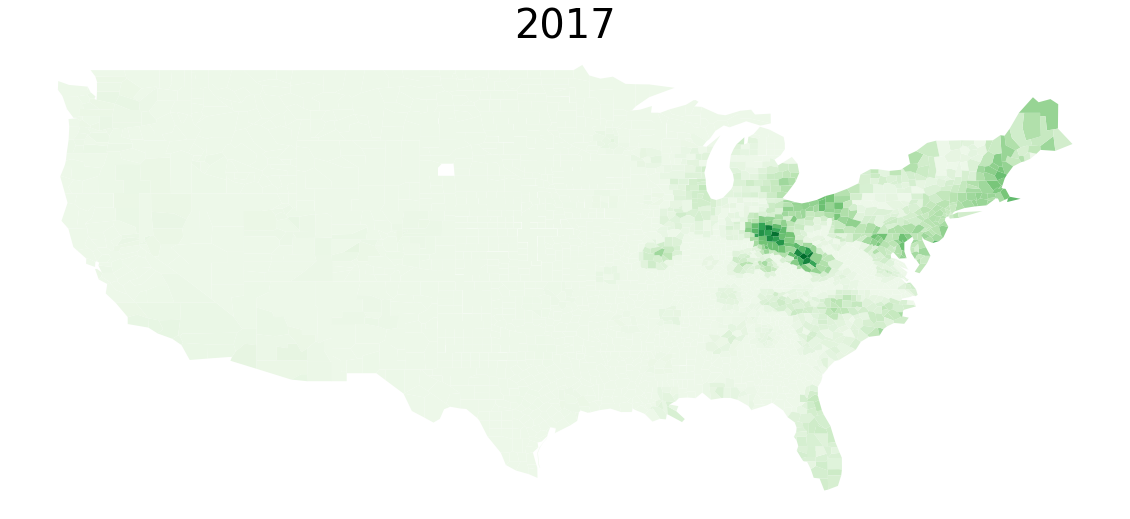

In [24]:
f, ax = plt.subplots(1, figsize=(20, 20))
ax = geo17.plot(column = 'rate_std_lag', ax = ax, cmap = cmap17)
plt.title('2017', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [25]:
print(ps.Moran(geodf[geodf.year == 2017]['calculated_crude_rate'], w17).p_sim)
print(ps.Moran(geodf[geodf.year == 2016]['calculated_crude_rate'], w16).p_sim)
print(ps.Moran(geodf[geodf.year == 2015]['calculated_crude_rate'], w15).p_sim)
print(ps.Moran(geodf[geodf.year == 2014]['calculated_crude_rate'], w14).p_sim)
print(ps.Moran(geodf[geodf.year == 2013]['calculated_crude_rate'], w13).p_sim)

0.001
0.001
0.001
0.001
0.001


/home/steve/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


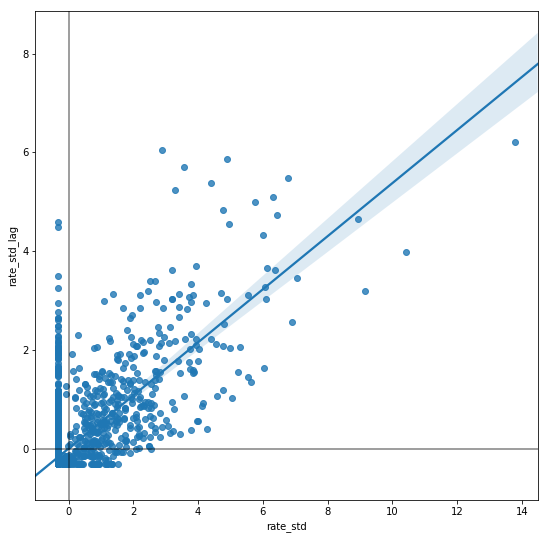

In [26]:
import seaborn as sns
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='rate_std', y='rate_std_lag', data=geo17)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [27]:
geo17.index = range(0, len(geo17))
lisa = ps.Moran_Local(geo17['calculated_crude_rate'].values, w17)

In [28]:
geo17['significant'] = lisa.p_sim <= 0.001
geo17['quadrant'] = lisa.q

/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
# converting the quadrant numbers for easier mapping, 1 and 3 are no difference and go to 0.5
# 2 is a low value next to a high value and goes to 0, 4 is a high value next to a low value and goes to 1
quad_dict = {1:0.5, 2:0, 3:0.5, 4:1}
geo17['quadrant_color'] = geo17.quadrant.map(quad_dict)

/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


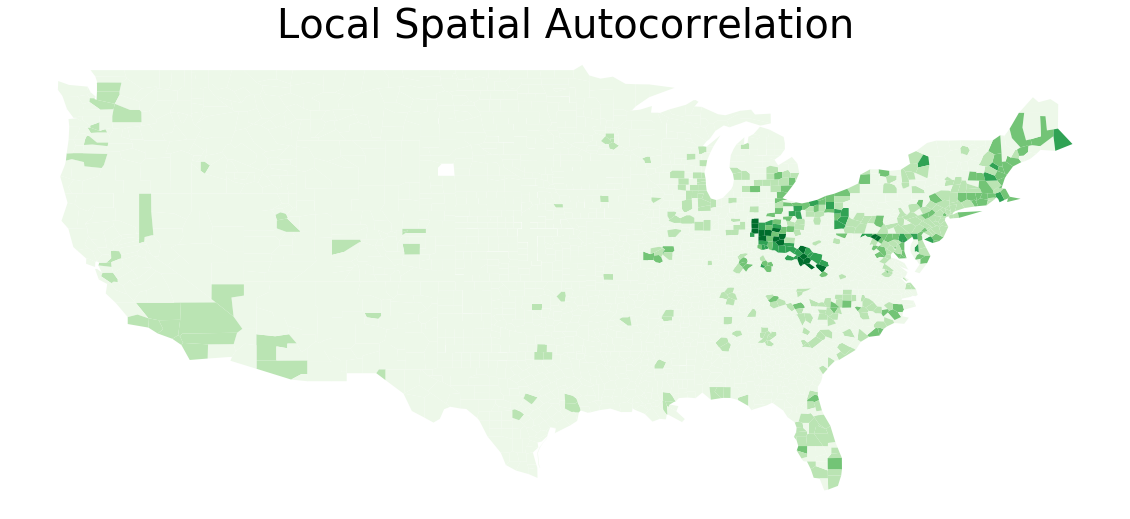

In [33]:
f, ax = plt.subplots(1, figsize=(20, 20))
# each year needs slightly different color maps because I want the maps to use the same colors across years
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#67a9cf'), (0.5, '#f7f7f7'), (1, '#ef8a62')])
ax = geodf[geodf.year == 2017].plot(column = 'test_color', ax = ax, cmap = cmap17)
# ax = geo17[geo17.quadrant_color != 0].plot(column = 'quadrant_color', ax = ax, cmap = cmap)
plt.title('Local Spatial Autocorrelation', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('lisa.png')

In [332]:
prescriptions_17 = pd.read_csv('2017_opioid_prescriptions.csv')

In [335]:
# test to see what's in the prescriptions that's not in existing database and vice versa then merge
# year by year autocorrelation
# correlation between total overdose deaths and fentanyl deaths
# graph of what is mixed with fentanyl
# make some correlation scatter plots

2969

In [355]:
prescriptions_17.columns = ['county', 'state', 'county_code', 'prescriptions']
geo17 = geo17.merge(prescriptions_17, on = 'county_code', how = 'left')

In [357]:
geo17.corr()

,county_code,year,deaths,crude_rate,aa_rate,calculated_crude_rate,test_color,percent_in_distress,rate_lag,rate_std,rate_std_lag,significant,quadrant,quadrant_color,prescriptions
county_code,1.000000,NaN,-0.007019,0.047090,0.047114,0.074736,0.059321,-0.098052,0.099364,0.074736,0.099364,0.040554,-0.090839,-0.072909,-0.136122
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deaths,-0.007019,NaN,1.000000,0.604116,0.579323,0.542519,0.563259,0.214257,0.417236,0.542519,0.417236,0.064559,-0.425491,0.118032,-0.059796
crude_rate,0.047090,NaN,0.604116,1.000000,0.997671,0.846193,0.774621,0.182648,0.647070,0.846193,0.647070,0.167987,-0.521706,0.101305,-0.010080
aa_rate,0.047114,NaN,0.579323,0.997671,1.000000,0.844409,0.770339,0.179590,0.648923,0.844409,0.648923,0.169820,-0.519385,0.098782,-0.006971
calculated_crude_rate,0.074736,NaN,0.542519,0.846193,0.844409,1.000000,0.950973,0.197946,0.725239,1.000000,0.725239,0.208713,-0.635722,0.148053,0.011584
test_color,0.059321,NaN,0.563259,0.774621,0.770339,0.950973,1.000000,0.238477,0.693346,0.950973,0.693346,0.185696,-0.646198,0.201354,-0.004881
percent_in_distress,-0.098052,NaN,0.214257,0.182648,0.179590,0.197946,0.238477,1.000000,0.194964,0.197946,0.194964,-0.033486,-0.233697,-0.009720,0.181957
rate_lag,0.099364,NaN,0.417236,0.647070,0.648923,0.725239,0.693346,0.194964,1.000000,0.725239,1.000000,0.245325,-0.735822,-0.288221,-0.033701
rate_std,0.074736,NaN,0.542519,0.846193,0.844409,1.000000,0.950973,0.197946,0.725239,1.000000,0.725239,0.208713,-0.635722,0.148053,0.011584


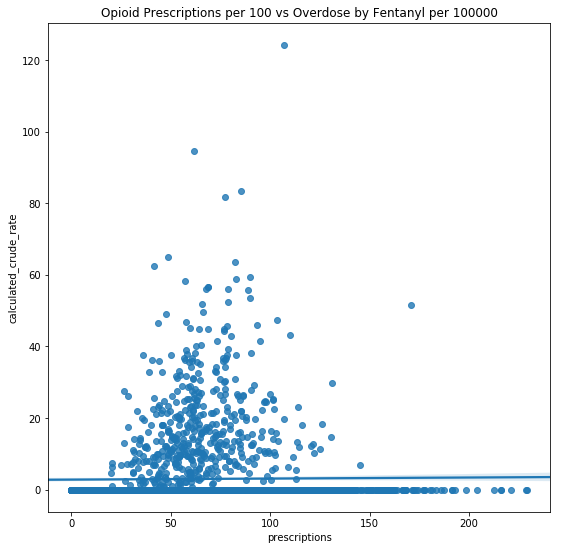

In [363]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='prescriptions', y='calculated_crude_rate', data=geo17)
plt.title('Opioid Prescriptions per 100 vs Overdose by Fentanyl per 100000')
plt.show()

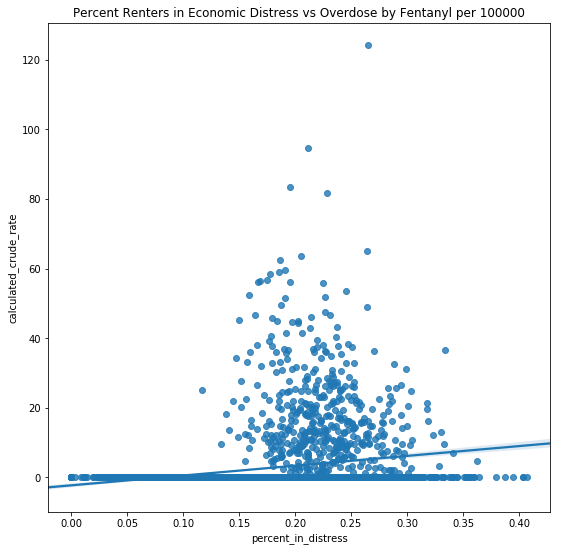

In [362]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='percent_in_distress', y='calculated_crude_rate', data=geo17)
plt.title('Percent Renters in Economic Distress vs Overdose by Fentanyl per 100000')
plt.show()

In [368]:
pd.read_csv('fent_county_year.txt', sep = '\t')

,Notes,County,County Code,Year,Year Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,"Autauga County, AL",1001.0,2013.0,2013.0,Suppressed,55246,Suppressed,Suppressed
1,NaN,"Autauga County, AL",1001.0,2014.0,2014.0,Suppressed,55395,Suppressed,Suppressed
2,NaN,"Autauga County, AL",1001.0,2015.0,2015.0,Suppressed,55347,Suppressed,Suppressed
3,NaN,"Autauga County, AL",1001.0,2016.0,2016.0,Suppressed,55416,Suppressed,Suppressed
4,NaN,"Autauga County, AL",1001.0,2017.0,2017.0,Suppressed,55504,Suppressed,Suppressed
5,NaN,"Baldwin County, AL",1003.0,2013.0,2013.0,Suppressed,195540,Suppressed,Suppressed
6,NaN,"Baldwin County, AL",1003.0,2014.0,2014.0,Suppressed,200111,Suppressed,Suppressed
7,NaN,"Baldwin County, AL",1003.0,2015.0,2015.0,Suppressed,203709,Suppressed,Suppressed
8,NaN,"Baldwin County, AL",1003.0,2016.0,2016.0,Suppressed,208563,Suppressed,Suppressed
9,NaN,"Baldwin County, AL",1003.0,2017.0,2017.0,Suppressed,212628,Suppressed,Suppressed


In [370]:
sum(geo17.deaths > 0)

475

In [371]:
geo17

,county_code,name,geometry,county_x,year,deaths,population,crude_rate,aa_rate,calculated_crude_rate,...,percent_in_distress,rate_lag,rate_std,rate_std_lag,significant,quadrant,quadrant_color,county_y,state_y,prescriptions
0,1001,Autauga,"POLYGON ((-86.41178600000001 32.706342, -86.41...","Autauga County, AL",2017.0,0,55504,0.0,0.0,0.000000,...,0.262802,0.000000,-0.319247,-0.319247,False,3,0.5,AUTAUGA,AL,106.6
1,1003,Baldwin,"POLYGON ((-87.76459 31.298768, -87.616713 31.2...","Baldwin County, AL",2017.0,0,212628,0.0,0.0,0.000000,...,0.209795,0.903740,-0.319247,-0.216706,False,3,0.5,BALDWIN,AL,106.7
2,1005,Barbour,"POLYGON ((-85.354736 32.147694, -85.053504 32....","Barbour County, AL",2017.0,0,25270,0.0,0.0,0.000000,...,0.210969,0.000000,-0.319247,-0.319247,True,3,0.5,BARBOUR,AL,90.7
3,1007,Bibb,"POLYGON ((-87.063542 33.248559, -87.025203 33....","Bibb County, AL",2017.0,0,22668,0.0,0.0,0.000000,...,0.200704,3.055752,-0.319247,0.027468,False,2,0.0,BIBB,AL,80.6
4,1009,Blount,"POLYGON ((-86.488463 34.261793, -86.455601 34....","Blount County, AL",2017.0,0,58013,0.0,0.0,0.000000,...,0.133438,4.708467,-0.319247,0.214990,False,2,0.0,BLOUNT,AL,48.9
5,1011,Bullock,"POLYGON ((-85.91886100000001 32.273663, -85.43...","Bullock County, AL",2017.0,0,10309,0.0,0.0,0.000000,...,0.379091,0.000000,-0.319247,-0.319247,False,3,0.5,BULLOCK,AL,19.9
6,1013,Butler,"POLYGON ((-86.477509 31.966955, -86.450124 31....","Butler County, AL",2017.0,0,19825,0.0,0.0,0.000000,...,0.143602,0.000000,-0.319247,-0.319247,False,3,0.5,BUTLER,AL,118.6
7,1015,Calhoun,"POLYGON ((-85.738122 33.966038, -85.5299980000...","Calhoun County, AL",2017.0,0,114728,0.0,0.0,0.000000,...,0.211533,2.919566,-0.319247,0.012016,False,2,0.0,CALHOUN,AL,138.2
8,1017,Chambers,"POLYGON ((-85.40402899999999 33.106158, -85.23...","Chambers County, AL",2017.0,0,33713,0.0,0.0,0.000000,...,0.161838,0.000000,-0.319247,-0.319247,False,3,0.5,CHAMBERS,AL,127.0
9,1019,Cherokee,"POLYGON ((-85.51356699999999 34.524686, -85.46...","Cherokee County, AL",2017.0,0,25857,0.0,0.0,0.000000,...,0.187712,2.085404,-0.319247,-0.082631,False,3,0.5,CHEROKEE,AL,128.3


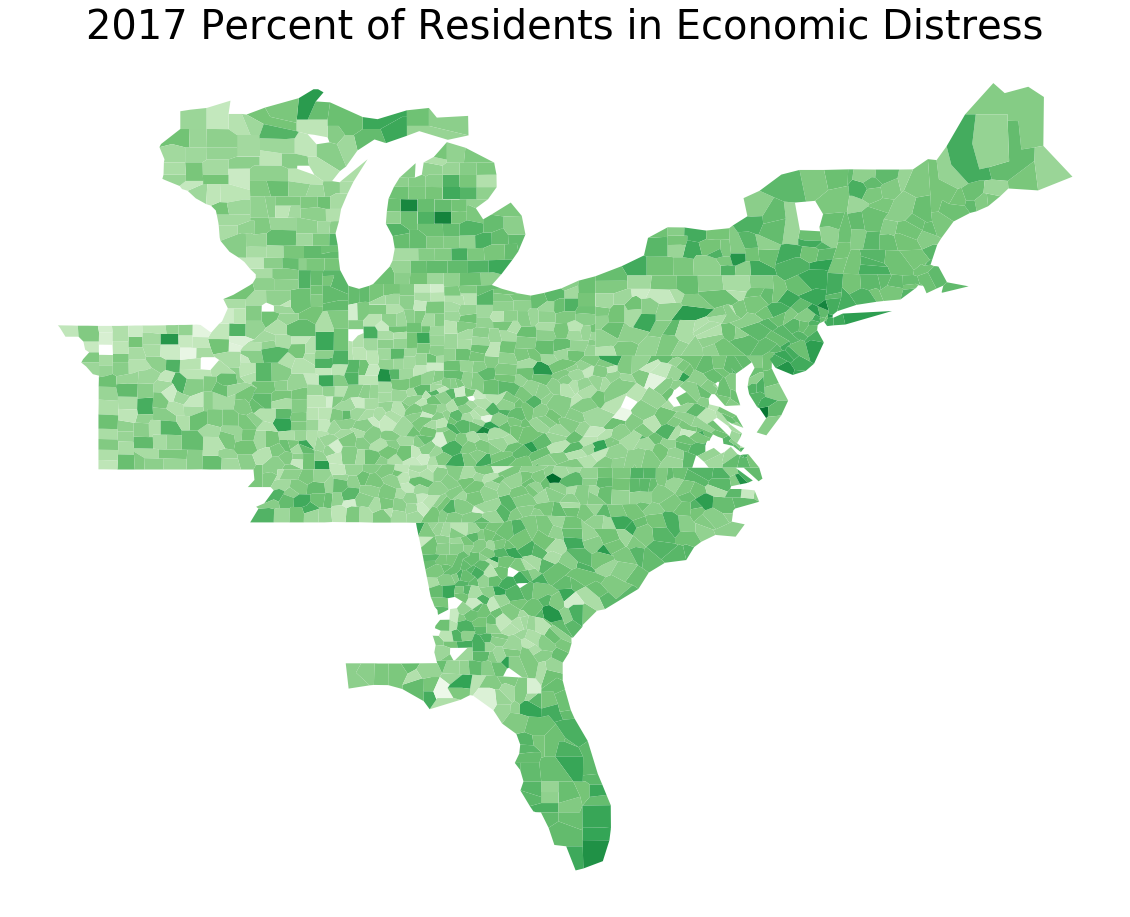

In [380]:
geo17[geo17['state_y'].isin(states)]
f, ax = plt.subplots(1, figsize=(20, 20))
ax = geo17[geo17['state_y'].isin(states)].plot(column = 'percent_in_distress', ax = ax, cmap = cmap17)
plt.title('2017 Percent of Residents in Economic Distress', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

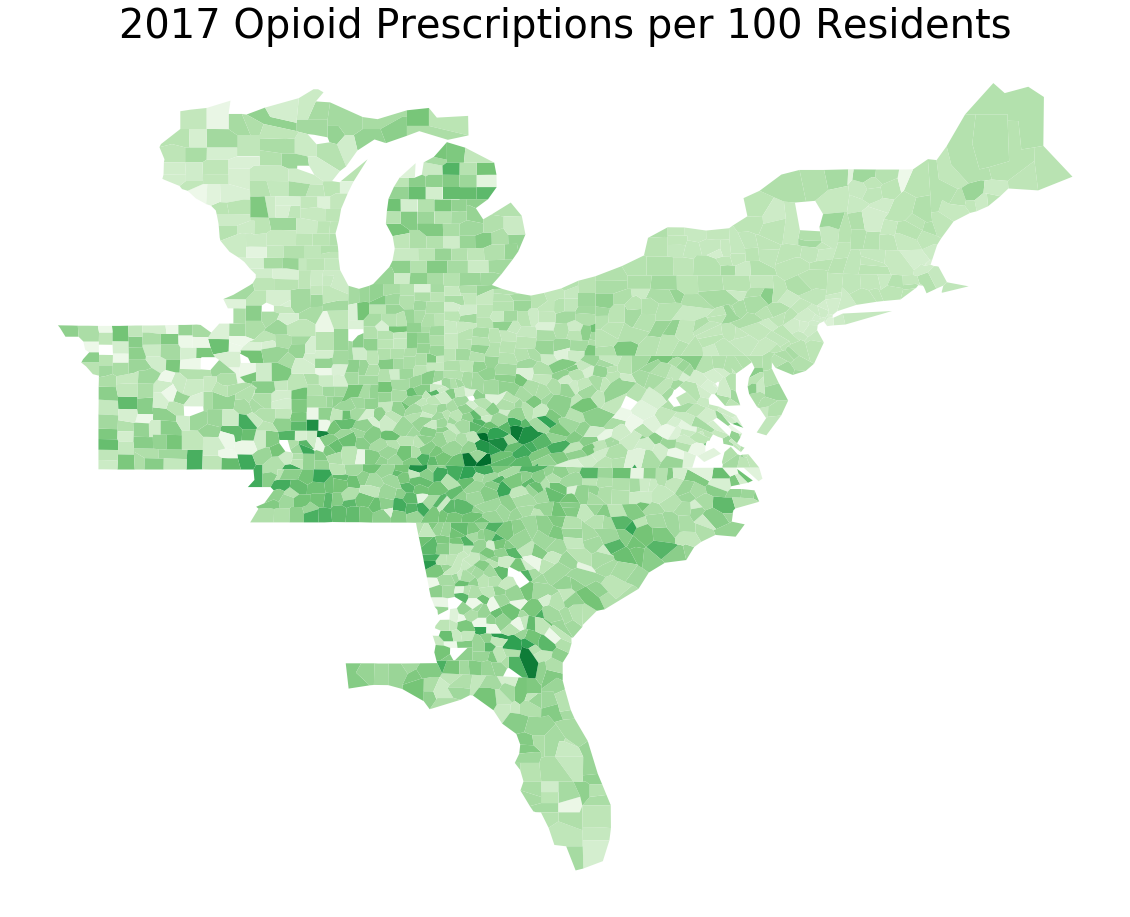

In [403]:
geo17[geo17['state_y'].isin(states)]
f, ax = plt.subplots(1, figsize=(20, 20))
ax = geo17[geo17['state_y'].isin(states)].dropna().plot(column = 'prescriptions', ax = ax, cmap = cmap17)
plt.title('2017 Opioid Prescriptions per 100 Residents', fontsize = 40)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [401]:
sum(geo17['prescriptions'].isna())

166

/home/steve/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


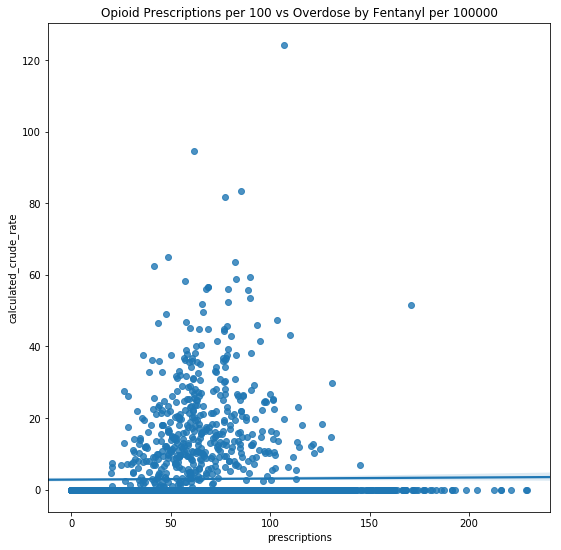

In [404]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='prescriptions', y='calculated_crude_rate', data=geo17)
plt.title('Opioid Prescriptions per 100 vs Overdose by Fentanyl per 100000')
plt.show()

In [1]:
geo17

NameError: name 'geo17' is not defined

In [11]:
fent_all_years.sort_values(by = 'deaths', ascending = False)

,county,county_code,deaths,population,crude_rate,aa_rate
613,"Cook County, IL",17031.0,1720,99632326.0,1.7,1.7
2248,"Allegheny County, PA",42003.0,1402,23560799.0,6.0,6.0
1315,"Wayne County, MI",26163.0,1263,35905338.0,3.5,3.5
2063,"Cuyahoga County, OH",39035.0,1196,24868211.0,4.8,4.8
1228,"Middlesex County, MA",25017.0,1034,28595780.0,3.6,3.4
1219,"Baltimore city, MD",24510.0,947,11895220.0,8.0,7.6
2102,"Montgomery County, OH",39113.0,909,10306472.0,8.8,9.2
2076,"Hamilton County, OH",39061.0,903,15475903.0,5.8,5.9
1882,"Suffolk County, NY",36103.0,777,28051087.0,2.8,2.8
1224,"Essex County, MA",25009.0,764,14147870.0,5.4,5.5


In [13]:
df[df.county == 'Cook County, IL']

,county,county_code,year,deaths,population,crude_rate,aa_rate
3065,"Cook County, IL",17031.0,2013.0,21,5240700,0.4,0.3
3066,"Cook County, IL",17031.0,2014.0,29,5246456,0.6,0.5
3067,"Cook County, IL",17031.0,2015.0,97,5238216,1.9,1.8
3068,"Cook County, IL",17031.0,2016.0,514,5203499,9.9,9.6
3069,"Cook County, IL",17031.0,2017.0,617,5211263,11.8,11.5
